# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
# для замера времени обучения моделей.
import time
import operator
# прогресс-бар.
from tqdm import trange
# для стандартизации данных по подбора ГП.
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# для сравнения моделей.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# модуль для разделения выборки.
from sklearn.model_selection import train_test_split
# модуль для получения структуры данных для классификации деревом решений.
from sklearn.tree import DecisionTreeClassifier, plot_tree
# модуль метрик качества.
from sklearn.metrics import accuracy_score
# модуль для работы со структурой данных "Случайный лес".
from sklearn.ensemble import RandomForestClassifier
# инициализация модели логистической регрессии.
from sklearn.linear_model import LogisticRegression
# инициализация модели простого классификатора.
from sklearn.dummy import DummyClassifier
# для построения графиков.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from IPython.display import display

In [2]:
# прочитаем файл данных.
try:
    # data = pd.read_csv('/datasets/data.csv')
    df=pd.read_csv('datasets/users_behavior.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [3]:
# посмотрим на тип данных и характеристики датасета.
display (df.describe())
df. head()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
# изменим тип данных 'calls' и 'messages' на 'int'.
convert_dict = {'calls': int,
                'messages': int}
df = df.astype(convert_dict)
print(df.dtypes)

calls         int64
minutes     float64
messages      int64
mb_used     float64
is_ultra      int64
dtype: object


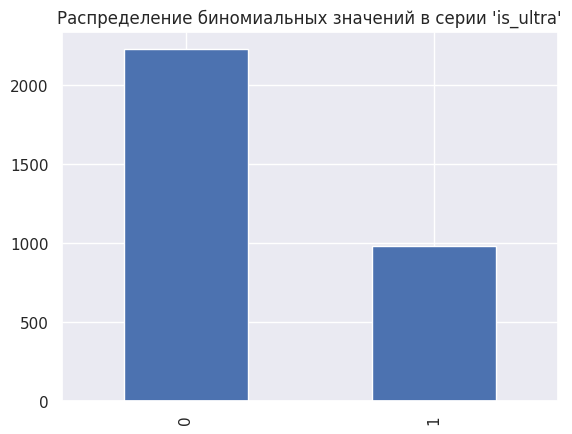

In [6]:
# посмотрим на распределение классов в данных.
df. is_ultra.value_counts().plot(kind='bar')
plt. title("Распределение биномиальных значений в серии 'is_ultra'")
plt. show()

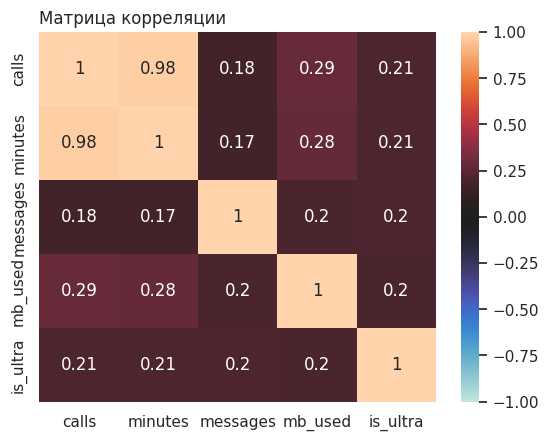

In [7]:
# построим матрицу корреляции.
sns.heatmap(df.corr(),annot=True,vmin=-1, vmax=1, center= 0)
plt.title("Матрица корреляции", loc="left")
plt. show()

Графики для выявления взаимосвязи между параметрами


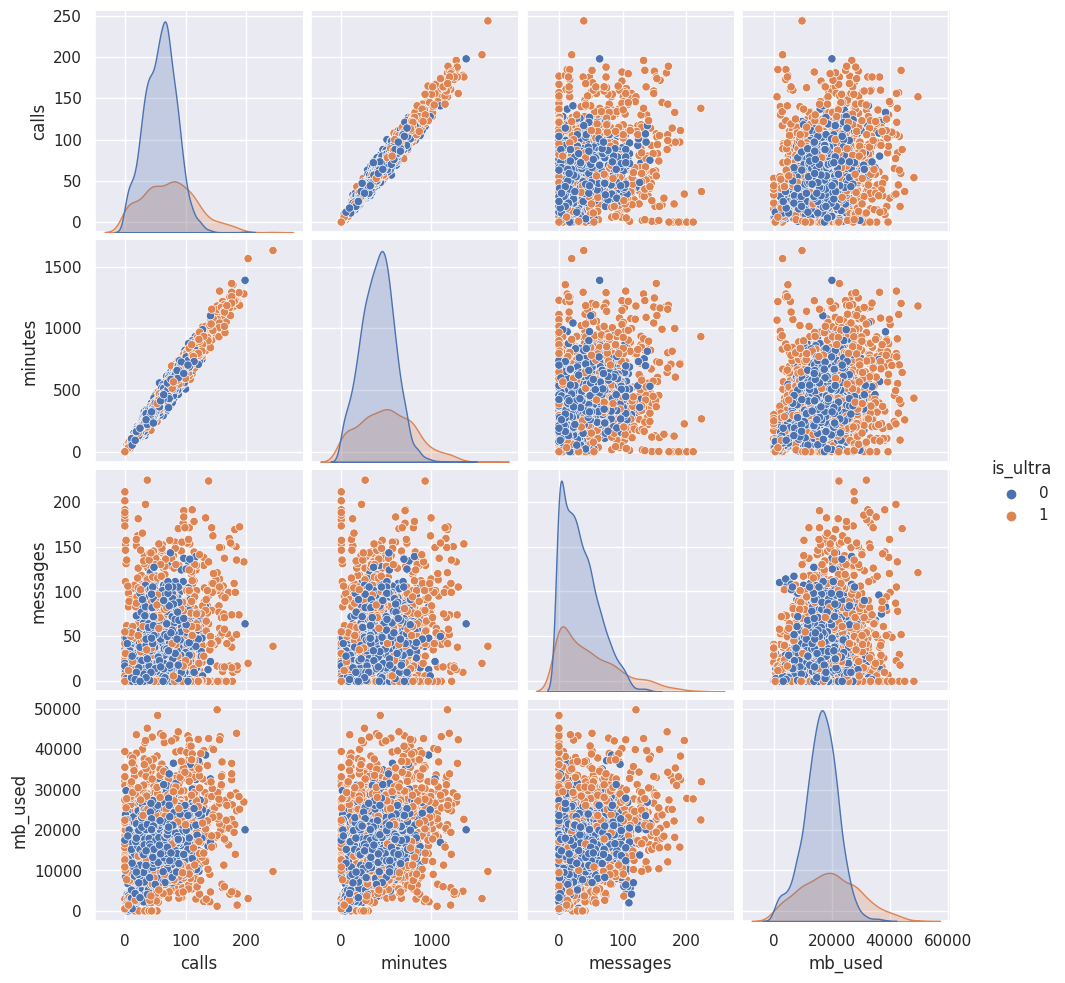

In [8]:
# построим график для визуализации взаимосвязи сразу нескольких количественных переменных.
# установим параметром hue данные из серии 'is_ultra'，чтобы увидеть распределение каждого тарифа по имеющимся признакам.
print("Графики для выявления взаимосвязи между параметрами")
sns.pairplot(df, hue="is_ultra")
plt. show()

### Вывод

    На данном этапе мы импортировали необходимые библиотеки для дальнейшей работы и ознакомились с датасетом по рекомендации тарифов.В нём были изменены серии 'calls' и 'messages' с типом данных 'float' на 'int'. Остальные этапы по предобработке данных были проделаны в прошлой работе, поэтому существенных изменений проводить не нужно.
    Так же был проведён анализ распределения классовых данных, из которых будут создаваться целевые выборки для обучения и тестирования моделей. Как видно из графика выше класс 0 превышает количество данных с классом 1 и это говорит о несбалансированности классов, которые превалируют в реальной практике, в таких случаях часто приходится прибегать к техникам искусственной модификации датасета для выравнивания соотношения классов, но в нашей работе такая задача не ставилась. Проанализировав график количественной взаимосвязи переменных и матрицу корреляции,можно сказать о высокой корреляции между ' calls' и 'minutes',а так же о наличии положительной скошенности графика с тарифом '1' по сравнению с тарифом '0'.Явного влияния признаков на целевой параметр не видно.
    Перейдем к этапу разделения датасета на выборки.

## Разбейте данные на выборки

In [9]:
# разделим датасет на выборки в соотношении 3:1:1
# по умолчанию параметр shuffle всегда True.
# Значит при создании выборки данные перемешиваются между собой для лучшего обучения модели.
df_train, df_other=train_test_split(df,test_size=0.25, random_state=12345,shuffle=True)
df_valid, df_test=train_test_split(df_other,test_size=0.5, random_state=12345,shuffle=True)
df_train_with_valid=pd.concat([df_train,df_valid],ignore_index=True, axis=0)
print('Size of Train Sample:', df_train.shape[0])
print('Size of Valid Sample:', df_valid.shape[0])
print('Size of Test Sample:', df_test.shape[0])
print()
print('Size of Sample for final training:', df_train_with_valid.shape[0])

Size of Train Sample: 2410
Size of Valid Sample: 402
Size of Test Sample: 402

Size of Sample for final training: 2812


In [10]:
# создадим выборки для обучения модели: признаки/предикаты -
# features и целевую выборку - targets.
features = df_train.drop('is_ultra', axis=1)
target = df_train['is_ultra']

# выборка валидационная
features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']

# выборка для проведения теста модели
features_test = df_test.drop('is_ultra', axis=1)
target_test = df_test['is_ultra']

In [11]:
# суммарная выборка для дообучения модели Дерева решений.
features_final= df_train_with_valid.drop('is_ultra', axis=1)
target_final= df_train_with_valid['is_ultra']

### Вывод

Мы разделили датасет на следующие выборки: для обучения, для валидации и для тестирования в соотношении 3:1:1. Так же для дообучения модели Дерева решений была создана выборка путём объединения тренировочной и валидационной выборки, чтобы улучшить прогноз по сравнению со Случайным лесом. Далее в каждой выборке были выделены признаки и целевые показатели.

## Исследуйте модели

Построим три основных модели по работе с классификационными данными: дерево решения, случайный лес и логистическая регрессия.

Дерево решений

100%|██████████| 50/50 [00:02<00:00, 17.69it/s]


Maximum accuracy for Validation Sample:
0.7985
with depth:
3
Maximum accuracy for Training Sample:
1.0
with depth:
25


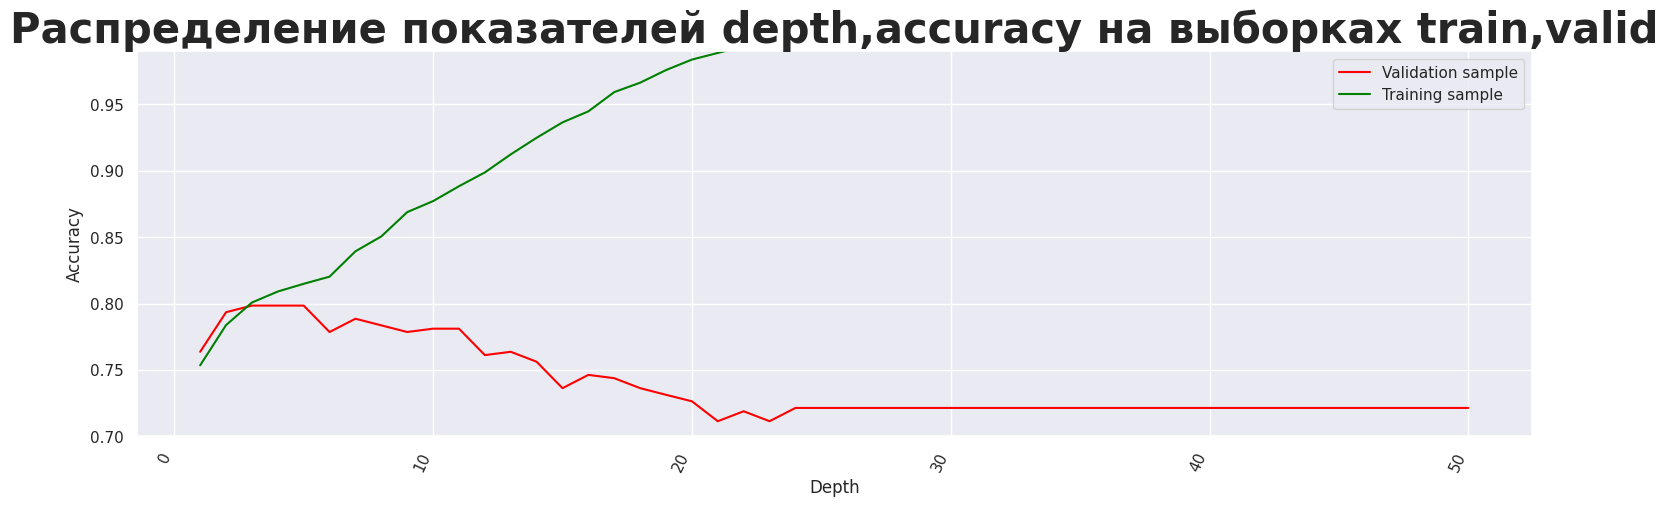

In [12]:
# создадим словари, куда будут
#поступать ключи/глубина дерева и соответствующий ей показатель accuracy.
valid_depth={}
train_depth={}
# используем trange из библиотеки tqdm для визуализации прогрессбара.
# создадим цикл для перебора depth.
for depth in trange(1,51):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features, target)
    predictions = model_tree.predict(features_valid)
    accuracy = round(accuracy_score(target_valid, predictions),4)
    accuracy_train_sample = round(model_tree.score(features, target),4)
    valid_depth[depth] = accuracy
    train_depth[depth] = accuracy_train_sample
# создадим переменные для максимальных значений depth по
# максимальному значению accuracy используя метод itemgetter из библиотеки operator.
train_max_depth=max(train_depth.items(),key=operator.itemgetter(1))[0]
valid_max_depth=max(valid_depth.items(),key=operator.itemgetter(1))[0]


print('Maximum accuracy for Validation Sample:',
valid_depth [valid_max_depth],
'with depth:',valid_max_depth,
'Maximum accuracy for Training Sample:',
train_depth [train_max_depth],
'with depth:',train_max_depth,sep='\n')

pd.Series(valid_depth).plot(kind='line',ylim=(.7,.85),figsize=(18,5),color='red')
pd.Series(train_depth).plot(kind='line',ylim=(.7,.99),figsize=(18,5), color='green')
plt.xticks(rotation=65, horizontalalignment='right')
plt. title ('Распределение показателей depth,accuracy на выборках train,valid', fontsize=30,fontweight='bold')
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.gca().legend(('Validation sample','Training sample'))
plt.show()

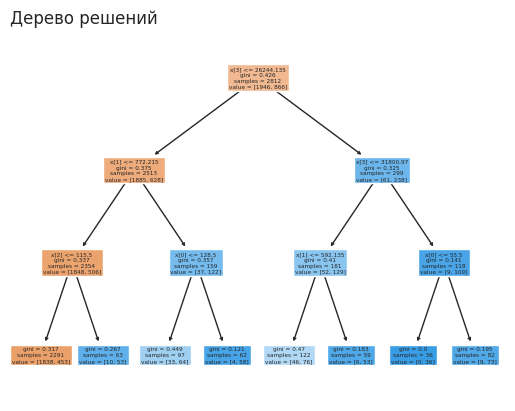

In [13]:
# обучим модель Дерево решений на подобранном ранее гиперпараметре max_depth по валидационной выборке.
model_tree = DecisionTreeClassifier(random_state=12345, max_depth=valid_max_depth)
# создадим переменную для отсчета стартового времени обучения
# с помощью метода monotonic (для точного представления измеряемого количества
# времени, вне зависимости от работы ОС и текущей платформы в отличие от метода time).
time_start = time. monotonic()
# используем для обучения увеличенную выборку.
model_tree.fit(features_final, target_final)
plot_tree(model_tree, filled=True)
plt.title("Дерево решений", loc="left")
plt.show()
# словарь для замера времени обучения.
time_spent={}
time_spent['DTC']=round((time.monotonic() - time_start),2)

### Вывод

Согласно графика выше глубина решающего дерева не должна быть больше значения 'valid_max_depth',иначе модель будет переобучена и её качество снизится. При данном гиперпараметре уровень accuracy составляет 0.79.

Случайный лес

100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


Maximum accuracy for Validation Sample:
0.801
with estim:
4
Maximum accuracy for Training Sample:
0.9992
with estim:
38


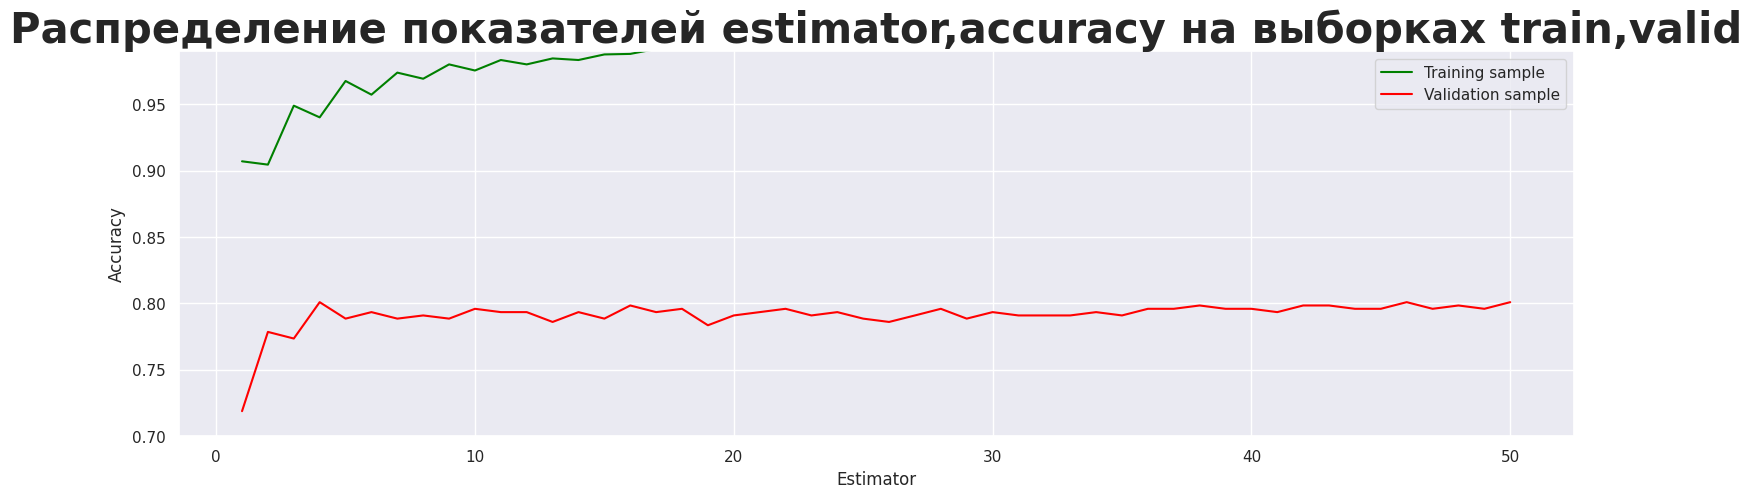

In [14]:
# создадим словари, куда будут
#поступать ключи/количество деревьев и соответствующий им показатель accuracy.
valid_estim,train_estim = {}, {}
# используем trange из библиотеки tqdm для визуализации прогрессбара.
# создадим цикл для перебора n_estimators.
for estim in trange(1,51):
    model_forest = RandomForestClassifier(random_state=12345,n_estimators=estim)
    model_forest.fit(features, target)
    score = round(model_forest.score(features_valid, target_valid),4)
    valid_estim[estim] = score
    score = round(model_forest.score(features, target),4)
    train_estim[estim] = score
# создадим переменные для максимальных значений n-estimators по
# максимальному значению accuracy используя метод itemgetter из библиотеки operator.
train_max_estim=max(train_estim.items(),key=operator.itemgetter(1))[0]
valid_max_estim=max(valid_estim.items(),key=operator.itemgetter(1))[0]

print('Maximum accuracy for Validation Sample:',
valid_estim [valid_max_estim],
'with estim:',valid_max_estim,
'Maximum accuracy for Training Sample:',
train_estim [train_max_estim],
'with estim:',train_max_estim,sep='\n')

# построим график.
pd.Series(train_estim).plot.line(ylim=(.7,.99),figsize=(18,5), color='green')
pd.Series(valid_estim).plot.line(ylim=(.7,.99), figsize=(18,5),color='red')
plt. title ('Распределение показателей estimator,accuracy на выборках train,valid', fontsize=30,fontweight='bold')
plt.ylabel('Accuracy')
plt.xlabel('Estimator')
plt.gca().legend(('Training sample','Validation sample'))
plt.show()

100%|██████████| 50/50 [00:01<00:00, 29.76it/s]


Maximum accuracy for Valid Sample:
0.8085
with depth:
7
with estim:
4
Maximum accuracy for Train Sample:
0.9448
with depth:
24
with estim:
38


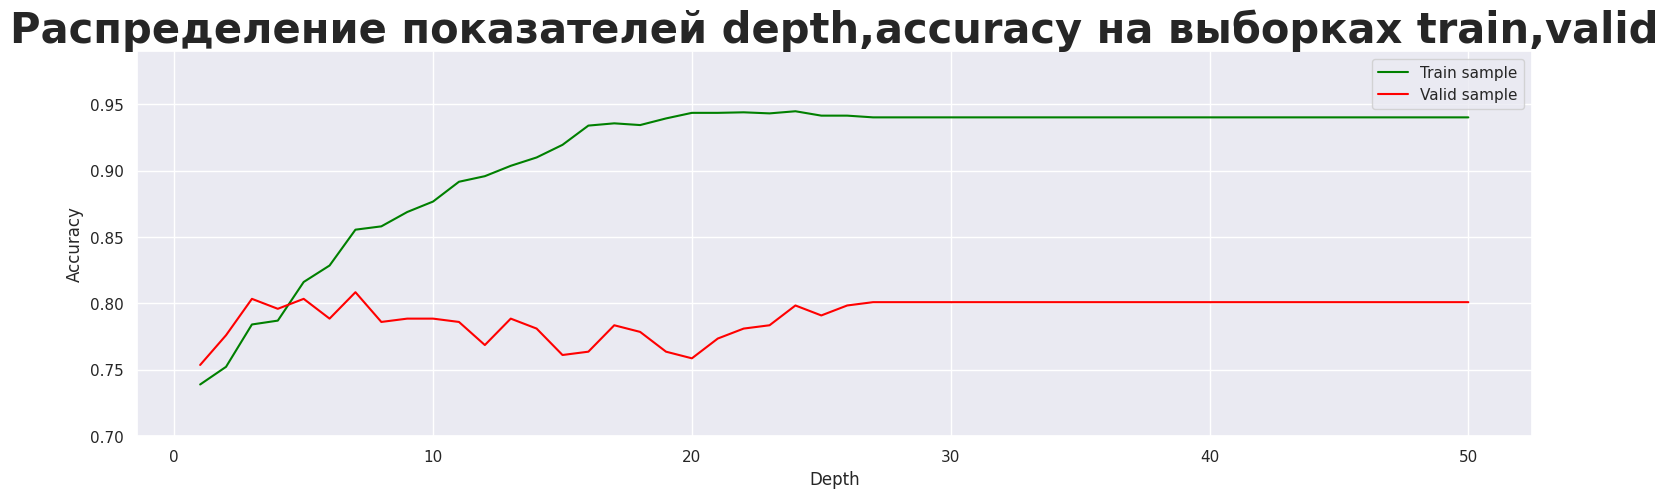

In [15]:
# теперь осуществим подбор гиперпараметра depth по известной нам n_estimators.
valid_depth, train_depth= {}, {}
for depth in trange (1,51):
    model_forest = RandomForestClassifier(random_state=12345,n_estimators=valid_max_estim, max_depth=depth)
    model_forest.fit(features, target)
    score = round(model_forest.score(features_valid, target_valid),4)
    valid_depth[depth] = score
    score = round(model_forest.score(features, target),4)
    train_depth[depth] = score

train_max_depth=max(train_depth.items(),key=operator.itemgetter(1))[0]
valid_max_depth=max(valid_depth.items(),key=operator.itemgetter(1))[0]


print('Maximum accuracy for Valid Sample:',
valid_depth [valid_max_depth],
'with depth:',valid_max_depth,
'with estim:', valid_max_estim,
'Maximum accuracy for Train Sample:',
train_depth [train_max_depth],
'with depth:',train_max_depth,
'with estim:',train_max_estim,sep='\n')

# построим график для наглядности.
pd.Series(train_depth).plot.line(ylim=(.7,.99),figsize=(18,5), color='green')
pd.Series(valid_depth).plot.line(ylim=(.7,.99), figsize=(18,5),color='red')
plt. title ('Распределение показателей depth,accuracy на выборках train,valid', fontsize=30,fontweight='bold')
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.gca().legend(('Train sample','Valid sample'))
plt.show()

Для поиска наиболее эффективных гиперпараметров для RandomForestClassifier  воспользуемся GridSearchCV и RandomizedSearchCV из библиотеки sklearn.

GridSearch— поиск лучших параметров в фиксированной сетке возможных значений.
CV – перекрёстная проверка (кросс-валидация, Cross-validation), метод, который показывает, что модель не переобучилась.
В отличие от GridSearchCV в RandomizedSearchCV,не все значения параметров опробованы,а из заданных распределений выбирается фиксированное количество параметров.Количество опробованных настроек параметров задается значением n_iter.

In [16]:
# посмотрим на имеющиеся гиперпараметры модели.
model_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 4,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

In [17]:
# создадим словарь, где укажем параметры, по которым
# будет осуществляться прогон для поиска наилучших сочетаний.
param = {
    'criterion': ['gini','entropy'],
    'max_depth': range(1,15,3),
    'n_estimators': range(1,20,3),
    'max_features': ['auto', 'sqrt', 'log2',  None],}
rf = RandomForestClassifier(random_state=12345)

# Пропишем параметры для GridSearchCV: estimator -модель, которую мы хотим обучить,
# param_grid - словарь с основными параметрами модели выше, которые мы хотим подобрать.
# cv - сколько разрезов кросс-валидации мы ходим сделать,
# n_jobs -количество паралельных процессов. Значение '-1' - задействованы все.
# verbose - насколько детальный отчёт мы хотим видеть.
# scoring — выбор метрики ошибки, в нашем случае accuracy.
grid_search = GridSearchCV(estimator = rf, param_grid = param,
                          cv = 5, n_jobs = -1, verbose = 1,scoring='accuracy')
grid_search.fit(features,target)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 15, 3),
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'n_estimators': range(1, 20, 3)},
             scoring='accuracy', verbose=1)

In [18]:
# посмотрим, какие наилучшие гиперпараметры для нашей модели.
print('Best parameters for RandomForestClassifier:')
display(grid_search.best_params_)
print('Accuracy training sample', 'with GridSearchCV for RFC:',round(grid_search.score(features,target),4),sep='\n')
print('Accuracy validation sample', 'with GridSearchCV for RFC:',round(grid_search.score(features_valid,target_valid),4),sep='\n')
new_param=grid_search.best_params_

Best parameters for RandomForestClassifier:


{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': None,
 'n_estimators': 13}

Accuracy training sample
with GridSearchCV for RFC:
0.8535
Accuracy validation sample
with GridSearchCV for RFC:
0.806


In [19]:
# с помощью библиотеки RandomizedSearchCV подберем гиперпараметры
# по такому же словарю 'param', который использовали с GridSearchCV. Посмотрим, кто справится лучше.
random_search =RandomizedSearchCV(rf,param, n_iter=5, cv=5, n_jobs=-1, verbose=1,scoring='accuracy')
random_search.fit(features,target)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 15, 3),
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'n_estimators': range(1, 20, 3)},
                   scoring='accuracy', verbose=1)

In [20]:
# посмотрим, какие наилучшие гиперпараметры для нашей модели.
print('Best parameters for RandomForestClassifier:')
display(random_search.best_params_)
print('Accuracy training sample', 'with RandomizedSearchCV for RFC:',round(random_search.score(features,target),4),sep='\n')
print('Accuracy validation sample', 'with RandomizedSearchCV for RFC:',round(random_search.score(features_valid,target_valid),4),sep='\n')
random_param=random_search.best_params_

Best parameters for RandomForestClassifier:


{'n_estimators': 10,
 'max_features': None,
 'max_depth': 7,
 'criterion': 'entropy'}

Accuracy training sample
with RandomizedSearchCV for RFC:
0.8506
Accuracy validation sample
with RandomizedSearchCV for RFC:
0.8109


### Вывод

Мы построили модель Случайный лес с подбором гиперпараметров 2 способами:

1.Подбор глубины и количества деревьев через 2 последовательных цикла. Был получен показатель accuracy на валидационной выборке равный 0.8.

2.Подбор гиперпараметров помимо глубины и количества деревьев ещё и количество признаков, которые следует учитывать при поиске лучшего сплита ('max_features'), а так же функции разделения ('criterion') с помощью библиотек GridSearchCV и RandomizedSearchCV, что дало такой результат accuracy - 0.8 на валидационной выборке, но с другими гиперпараметрами.

Сравним 3 модели по получившемся 2мя способами подбора гиперпараметров на тестовой выборке.

Логическая регрессия

In [21]:
# Логическая регрессия без нормализации данных.
model_lp = LogisticRegression(random_state=12345)
model_lp.fit(features, target)
score = model_lp.score(features_valid, target_valid)
score_train = model_lp.score(features, target)

print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(score_train))
print('Accuracy of logistic regression classifier on validation set: {:.4f}'.format(score))

Accuracy of logistic regression classifier on train set: 0.7025
Accuracy of logistic regression classifier on validation set: 0.7040


In [22]:
# Логическая регрессия с нормализацией данных при помощи MinMaxscaler().
logreg = LogisticRegression(random_state=12345)
scaler=MinMaxScaler(feature_range = (0,1))
log_f=scaler.fit_transform(features)
log_val=scaler.transform(features_valid)
log_test=scaler.transform(features_test)
logreg.fit(log_f, target)
time_spent['LR']=round((time.monotonic() - time_start),2)
print('Accuracy of logistic regression classifier on train set: {:.4f}'.
      format(logreg.score(log_f, target)))
print('Accuracy of logistic regression classifier on validation set: {:.4f}'.
      format(logreg.score(log_val, target_valid)))

Accuracy of logistic regression classifier on train set: 0.7407
Accuracy of logistic regression classifier on validation set: 0.7711


### Вывод

Модель  LogisticRegression дает лучший показатель accuracy равный 0.77 при нормализации данных с помощью MinMaxScaler. При проверке на тестовой выборке будем использовать именно эту модель.

## Проверьте модель на тестовой выборке

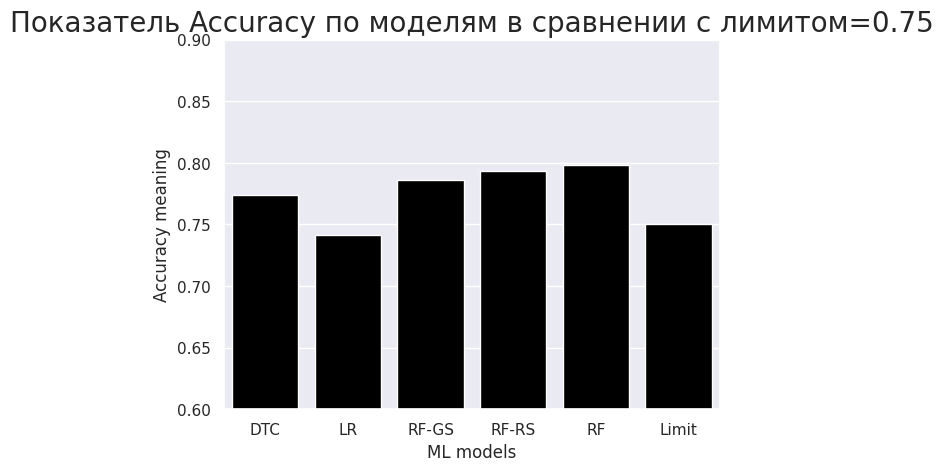

,DTC,LR,RF-GS,RF-RS,RF,Limit
accuracy,0.7736,0.7413,0.7861,0.7935,0.7985,0.75


In [23]:
# обучим модель Случайного леса на гиперпараметрах, полученных с помощью GridSearchCV.
model_forest_gs= RandomForestClassifier(random_state=12345,
criterion=new_param['criterion'],
n_estimators=new_param['n_estimators'],
max_depth=new_param['max_depth'],
max_features = new_param['max_features'])
model_forest_gs.fit(features, target)
time_spent['RF_GS']=round((time.monotonic() - time_start),2)


# обучим модель Случайного леса на гиперпараметрах, полученных с помощью RandomizedSearchCV.
model_forest_random= RandomForestClassifier(random_state=12345,
criterion=random_param['criterion'],
n_estimators=random_param['n_estimators'],
max_depth=random_param['max_depth'],
max_features = random_param['max_features'])
model_forest_random.fit(features, target)
time_spent['RF_RS']=round((time.monotonic() - time_start),2)


# обучим модель Случайного леса на параметрах, полученных подбором через цикл.
model_forest= RandomForestClassifier(random_state=12345,
n_estimators=valid_max_estim,
max_depth=valid_max_depth)
model_forest.fit(features, target)
time_spent['RF']=round((time.monotonic() - time_start),2)


# сохраним предсказания на тестовой выборке по каждой модели для дальнейшего анализа.
predict_forest_gs= model_forest_gs.predict(features_test)
predict_forest_random= model_forest_random.predict(features_test)
predict_forest= model_forest.predict(features_test)
predict_logreg= logreg.predict(log_test)
predict_tree= model_tree.predict(features_test)


# сохраним результаты в датафрейм и построим график.
all_models=pd.DataFrame({'DTC': [round(model_tree.score(features_test, target_test),4)],
'LR': [round(logreg.score(log_test, target_test),4)],
'RF-GS': [round(model_forest_gs.score(features_test, target_test),4)],
'RF-RS': [round(model_forest_random.score(features_test, target_test),4)],
'RF': [round(model_forest.score(features_test, target_test),4)], 'Limit' :[0.75]}, index=['accuracy'])
g=sns.barplot(data=all_models,color='black')
g.set_title('Показатель Accuracy по моделям в сравнении с лимитом=0.75',fontdict={'fontsize':20})
g.set_ylim(bottom=0.6, top=0.9)
g.set(xlabel='ML models', ylabel='Accuracy meaning')
plt. show()
all_models

Посмотрим на скорость обучения моделей.

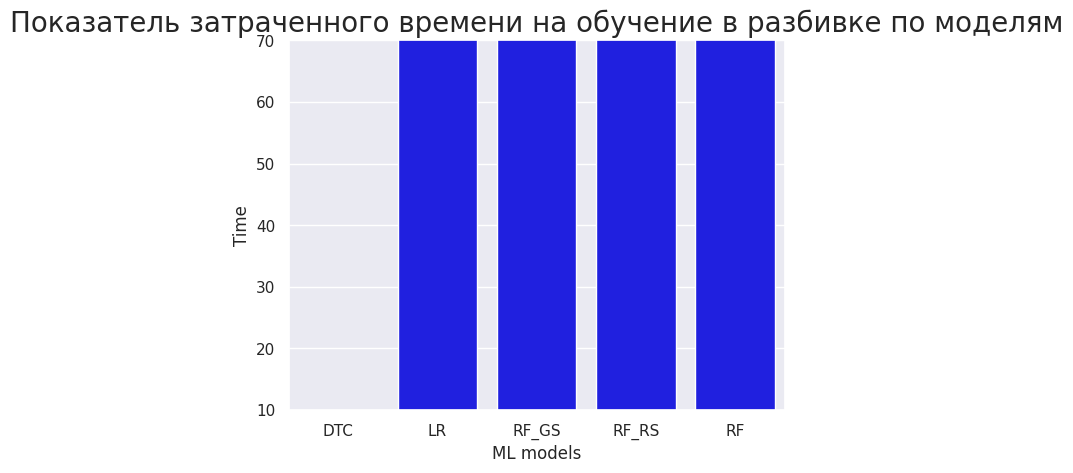

,DTC,LR,RF_GS,RF_RS,RF
time,1.66,80.82,80.98,81.06,81.08


In [24]:
time_train=pd.DataFrame(time_spent, index=['time'])
w=sns.barplot(data=time_train,color='blue')
w.set_title('Показатель затраченного времени на обучение в разбивке по моделям',fontdict={'fontsize':20})
w.set_ylim(bottom=10, top=70)
w.set(xlabel='ML models', ylabel='Time')
plt. show()
time_train

Построим матрицы неточностей, показывающие точность прогнозирования классификатора в отношении имеющихся двух классов и классификационные отчёты для сравнения успешного обучения моделей.

Случайный лес

In [25]:
# построим матрицу неточностей и классификационный отчёт.
confusion = confusion_matrix(target_test, predict_forest)
print("Confusion matrix:\n{}".format(confusion))
print(classification_report(predict_forest, target_test))

Confusion matrix:
[[266  17]
 [ 64  55]]
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       330
           1       0.46      0.76      0.58        72

    accuracy                           0.80       402
   macro avg       0.70      0.78      0.72       402
weighted avg       0.85      0.80      0.82       402



Случайный лес (RandomizedSearchCV)

In [26]:
confusion = confusion_matrix(target_test, predict_forest_random)
print("Confusion matrix:\n{}".format(confusion))
print(classification_report(predict_forest_random, target_test))

Confusion matrix:
[[266  17]
 [ 66  53]]
              precision    recall  f1-score   support

           0       0.94      0.80      0.87       332
           1       0.45      0.76      0.56        70

    accuracy                           0.79       402
   macro avg       0.69      0.78      0.71       402
weighted avg       0.85      0.79      0.81       402



Случайный лес (GridSearchCV)

In [27]:
confusion = confusion_matrix(target_test, predict_forest_gs)
print("Confusion matrix:\n{}".format(confusion))
print(classification_report(predict_forest_gs, target_test))

Confusion matrix:
[[265  18]
 [ 68  51]]
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       333
           1       0.43      0.74      0.54        69

    accuracy                           0.79       402
   macro avg       0.68      0.77      0.70       402
weighted avg       0.85      0.79      0.81       402



Логическая регрессия

In [28]:
confusion = confusion_matrix(target_test, predict_logreg)
print("Confusion matrix:\n{}".format(confusion))
print(classification_report(predict_logreg, target_test))

Confusion matrix:
[[279   4]
 [100  19]]
              precision    recall  f1-score   support

           0       0.99      0.74      0.84       379
           1       0.16      0.83      0.27        23

    accuracy                           0.74       402
   macro avg       0.57      0.78      0.56       402
weighted avg       0.94      0.74      0.81       402



Дерево решений

In [29]:
confusion = confusion_matrix(target_test, predict_tree)
print("Confusion matrix:\n{}".format(confusion))
print(classification_report(predict_tree, target_test))

Confusion matrix:
[[267  16]
 [ 75  44]]
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       342
           1       0.37      0.73      0.49        60

    accuracy                           0.77       402
   macro avg       0.66      0.76      0.67       402
weighted avg       0.86      0.77      0.80       402



### Вывод

    Вывод:

    Было обучено 3 модели машинного обучения на основе библиотеки sklearn:

    - Логическая регрессия (LogisticRegression)
    - Случайный лес (RandomForestClassifier)
    - Дерево решений (DecisionTreeClassifier)

    В рамках данного проекта было решено не только найти наиболее эффективную модель по показателю accuracy, но и 'поиграть с тюнингом' этих моделей.

    На модели Дерева решений было проведено обучение на увеличенной тренировочной выборке за счёт объединения с валидационной. Данное решение было применено для увеличения точности прогноза, т. к. данная модель обучается быстрее остальных.

    На модели Случайного леса были проведены подборы гиперпараметров с помощью цикла (количество деревьев и глубина) и подбор расширенного списка гиперпараметров с помощью GridSearchCV и RandomizedSearchCV.

    На Логической регрессии посмотрели, как себя ведëт модель с предварительной нормализацией и стандартизацией данных с использованием MinMaxScaler и без. Модель с обработкой данных показала лучший accuracy на валидационной выборке и в дальнейшем именно она проверялась на тестовой выборке.

    На тестовой проверке моделей мы убедились, что модель Случайного леса после подбора ГП RandomizedSearchCV показывает себя лучшим образом среди остальных моделей машинного обучения, но и такие модели как Случайный лес, Случайный лес с подбором GridSearchCV, Дерево решений перешагнули пороговое значение accuracy 0.75 ('Limit') в рамках нашего задания. Логическая регрессия не добрала сотых долей до порога.

    Решение с созданием выборки для дообучения Дерева решений улучшило точность данной модели.Надо отметить,что данная модель  обучается быстрее остальных моделей.

    Так как в целевых данных классы сильно разбалансированы, то показатель accuracy может ввести в заблуждение. Решено было так же проанализировать матрицы неточностей и классификационные отчеты в части показателей macro avg и average avg по показателю f1-score (у нас нет предпочтений по классам) и по нему мы так же убедились в успешном обучении модели Случайного леса после RandomizedSearchCV.

## (бонус) Проверьте модели на адекватность

Для проверки модели создадим baseline модель DummyClassifier для определения минимально ожидаемой производительности по поставленной задаче.

In [30]:
model_dc = DummyClassifier(strategy='most_frequent', random_state=12345)
model_dc.fit(features, target)
result_dc = model_dc.score(features_test, target_test)
print('Accuracy DummyClassifier:', round(result_dc,4))

Accuracy DummyClassifier: 0.704


### Вывод

Baseline модель DummyClassifier показала, что минимальный порог адекватного accuracy составляет 0.704.У данной модели машинного обучения нет никакого представления о данных и она классифицирует данные, используя только простые правила. Поведение данного классификатора полностью не зависит от обучающих данных, поскольку тенденции в обучающих данных полностью игнорируются и вместо этого используется одна из стратегий для прогнозирования метки класса. Следовательно все модели построенные выше проходят более сложный алгоритм обучения на данных и то, что accuracy каждой из них выше 0.704 свидетельствует об их адекватности.

